In [66]:
from keras.models import Sequential
from keras.layers import Dense, GRU
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import os

# Suppress TensorFlow logging



In [67]:
# Load the data sets and combine them into a single usable dataframe called data series
data_series = pd.read_csv('./data/data_avg_temp.csv')

# rename columns to be more descriptive
data_series.columns = ['date', 'avg_temp', 'avg_temp_anomaly']
data_series.drop(columns=['avg_temp_anomaly'], inplace=True)

# append to the dataframe
data_cool_degree = pd.read_csv('./data/data_cool_degree_days.csv')
data_heat_degree = pd.read_csv('./data/data_heat_degree_days.csv')
data_max_temp = pd.read_csv('./data/data_max_temp.csv')
data_min_temp = pd.read_csv('./data/data_min_temp.csv')
data_palmer_z = pd.read_csv('./data/data_palmer_z.csv')
data_pdsi = pd.read_csv('./data/data_pdsi.csv')
data_phdi = pd.read_csv('./data/data_phdi.csv')
data_pmdi = pd.read_csv('./data/data_pmdi.csv')
data_precipitation = pd.read_csv('./data/data_precipitation.csv')



# Append columns to the data series
data_series['cool_degree_days'] = data_cool_degree['Value']
# data_series['cool_degree_days_anomaly'] = data_cool_degree['Anomaly']

data_series['heat_degree_days'] = data_heat_degree['Value']
# data_series['heat_degree_days_anomaly'] = data_heat_degree['Anomaly']

data_series['max_temp'] = data_max_temp['Value']
# data_series['max_temp_anomaly'] = data_max_temp['Anomaly']

data_series['min_temp'] = data_min_temp['Value']
# data_series['min_temp_anomaly'] = data_min_temp['Anomaly']

data_series['palmer_z'] = data_palmer_z['Value']
# data_series['palmer_z_anomaly'] = data_palmer_z['Anomaly']

data_series['pdsi'] = data_pdsi['Value']
# data_series['pdsi_anomaly'] = data_pdsi['Anomaly']

data_series['phdi'] = data_phdi['Value']
# data_series['phdi_anomaly'] = data_phdi['Anomaly']

data_series['pmdi'] = data_pmdi['Value']
# data_series['pmdi_anomaly'] = data_pmdi['Anomaly']

data_series['precipitation'] = data_precipitation['Value']
# data_series['precipitation_anomaly'] = data_precipitation['Anomaly']




In [68]:
# Convert dataframe to numpy array
avg_temp = data_series['avg_temp'].to_numpy()
data_series.drop(columns=['avg_temp'], inplace=True)

print(data_series.columns)
print(data_series.head())
x = data_series.to_numpy()

# Expand first dim
x = np.expand_dims(x, axis=0)
avg_temp = np.expand_dims(avg_temp, axis=0)

# print(x)


Index(['date', 'cool_degree_days', 'heat_degree_days', 'max_temp', 'min_temp',
       'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation'],
      dtype='object')
     date  cool_degree_days  heat_degree_days  max_temp  min_temp  palmer_z  \
0  189512               621              5329      65.3      37.1      2.15   
1  189601               621              5249      65.6      37.1      2.55   
2  189602               621              5108      66.2      37.5     -0.91   
3  189603               621              5066      66.3      37.5      0.20   
4  189604               623              5066      66.4      37.4      6.88   

   pdsi  phdi  pmdi  precipitation  
0  0.72  0.72  0.72          16.53  
1  1.49  1.49  1.49          16.10  
2  1.04  1.04  0.47          15.55  
3  0.99  0.99  0.48          15.64  
4  3.19  3.19  3.19          15.83  


In [69]:
# Train the GRU model
model_gru = Sequential(
    [
        GRU(20, activation='relu', input_shape=(x.shape[1], x.shape[2])),
        Dense(1)
    ]
)

model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(x, avg_temp, epochs=300, batch_size=1)


Epoch 1/300


/home/frederik/miniconda3/envs/ml_new_mexico/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step - loss: 410863168.0000
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 392124672.0000
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 373854752.0000
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 356059712.0000
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 338743488.0000
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 322289216.0000
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 306518688.0000
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 291183808.0000
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 276288512.0000
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 261834544.0000
Epoch 11/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 247824432.0000
Epoch 12/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 234258992.0000
Epoch 13/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 221138944.0000
Epoch 14/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss

In [70]:
# Predict the temperature by regressing the other features and then predicting average temperature
parameters = ['cool_degree_days', 'heat_degree_days', 'max_temp', 
              'min_temp', 'palmer_z', 'pdsi',
              'phdi', 'pmdi', 'precipitation']
# parameters = ['cool_degree_days']
models = {}
scalers = {}

date = data_series['date'].to_numpy()
date_splice = np.zeros((len(date), 2))

param_models = []

for i, element in enumerate(date):
    # print(element)
    # Splice this string to get year and month
    date_splice[i,0] = int(str(element)[0:4])
    date_splice[i,1] = int(str(element)[5:7])

for param in parameters:
    print(f"PARAM", param)
    y = data_series[param].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(date_splice, y, test_size=0.2, shuffle=False)

    model = Sequential([
        Dense(5, activation='relu', input_shape=(X_train.shape[1],)),  # input_shape=(2,)
        Dense(1)  # Output layer
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_test, y_test))

    # Save model
    param_models.append(model)

    # Cool degrees (Pdsi)

PARAM cool_degree_days
Epoch 1/300


/home/frederik/miniconda3/envs/ml_new_mexico/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6272479.0000 - val_loss: 7173653.0000
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5492318.5000 - val_loss: 6327754.0000
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4800531.0000 - val_loss: 5568113.0000
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4160220.2500 - val_loss: 4889427.0000
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3611464.5000 - val_loss: 4285029.5000
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3117489.5000 - val_loss: 3747403.7500
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2667670.2500 - val_loss: 3270045.0000
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2288235.7500 - val_loss: 2845808.5000
Epoch 9/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1954043.1250 - val_loss: 2470769.7500
Epoch 10/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1660609.1250 - val_loss: 2140456.0000
Epoch 11/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0

In [71]:
# Prediction of the average temperature
# Using the trained models to predict the parameters and then use those predictions as input for the GRU model

# Predict the parameters for the next 5 year * 12 months (60 datapoints)

# Get dates for prediction (202401-202812)
years = 60
date_predict = np.zeros((years*12, 2))
for i in range(years*12):
    date_predict[i, 0] = 2024 + i // 12
    date_predict[i, 1] = 1 + i % 12


param_predicts = np.zeros((len(parameters),years*12))

#  Predict the parameters.
for k, model in enumerate(param_models):
    for i in range(years*12):
        answer = model.predict(date_predict[i].reshape(1, -1))
        param_predicts[k, i] = answer

yearmonth_vec = np.zeros((years*12,1))
for i in range(years*12):
    yearmonth_vec[i] = date_predict[i, 0] * 100 + date_predict[i, 1]

params_predicts = np.append(yearmonth_vec, param_predicts.T, axis=1)

print(params_predicts)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/tmp/ipykernel_1095418/3085142658.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  param_predicts[k, i] = answer


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━

In [72]:
for i in range(years*12):
    print(f"Year: {int(params_predicts[i,0]//100)} Month: {int(params_predicts[i,0]%100)}")
    print(f"Predicted parameters:")
    for j, param in enumerate(parameters):
        print(f"{param}: {params_predicts[i,j+1]}")

Year: 2024 Month: 1
Predicted parameters:
cool_degree_days: 847.36865234375
heat_degree_days: 5090.21630859375
max_temp: 2.0554516315460205
min_temp: 40.078399658203125
palmer_z: 0.1892058253288269
pdsi: 0.5049615502357483
phdi: 0.7210316061973572
pmdi: 1.7297228574752808
precipitation: 1.7800017595291138
Year: 2024 Month: 2
Predicted parameters:
cool_degree_days: 846.6371459960938
heat_degree_days: 5093.51953125
max_temp: 2.0554516315460205
min_temp: 39.96043014526367
palmer_z: 0.17763486504554749
pdsi: 0.48356157541275024
phdi: 0.7101905941963196
pmdi: 1.2470742464065552
precipitation: 1.7800017595291138
Year: 2024 Month: 3
Predicted parameters:
cool_degree_days: 845.9055786132812
heat_degree_days: 5096.82177734375
max_temp: 2.0554516315460205
min_temp: 39.84233856201172
palmer_z: 0.16618597507476807
pdsi: 0.4621753692626953
phdi: 0.6993486285209656
pmdi: 0.7642902135848999
precipitation: 1.7800017595291138
Year: 2024 Month: 4
Predicted parameters:
cool_degree_days: 845.174072265625


In [73]:

# Use predicted params for GRU input to predict avg_temp
predictions = []

for i in range(years*12):
    new_timestep = params_predicts[i,:]
    new_timestep = np.expand_dims(new_timestep, axis=0)
    x = np.append(x[:,1:,:], np.expand_dims(new_timestep, axis=0), axis=1)

    # x = np.expand_dims(params_predicts[i, :], axis=0)
    avg_temp_predict = model_gru.predict(x)
    predictions.append(avg_temp_predict)


print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

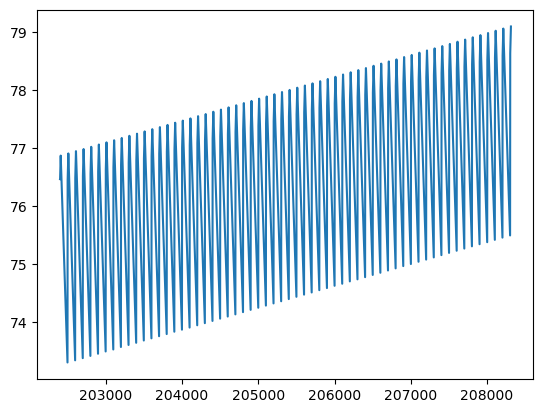

In [ ]:
# plot the predictions
predictions = np.array(predictions).reshape(-1)
plt.plot(yearmonth_vec[2:], predictions[2:], label='Predicted')

print(predictions)